# Download data

In [1]:
import yfinance as yf
import pandas as pd

# Download historical stock data
ticker = "AAPL"
start_date = "2010-01-01"
end_date = "2023-12-31"
data = yf.download(ticker, start=start_date, end=end_date)

# Save to CSV
data.to_csv(f"{ticker}_stock_data.csv")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [2]:
df = pd.read_csv('AAPL_stock_data.csv')
df.head()

,Price,Close,High,Low,Open,Volume
0,Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
1,Date,NaN,NaN,NaN,NaN,NaN
2,2010-01-04,6.431896209716797,6.446622696457914,6.382907969735801,6.414464784362005,493729600
3,2010-01-05,6.443017959594727,6.479383562143956,6.409056346197433,6.449630033246135,601904800
4,2010-01-06,6.3405327796936035,6.46856375161783,6.333920706507196,6.443017506482532,552160000


In [3]:
import pandas as pd
import numpy as np

# Load the data with proper handling
try:
    # First attempt - skip 2 rows and check structure
    df = pd.read_csv("AAPL_stock_data.csv", skiprows=2, header=None)
    
    # Verify we have the expected number of columns
    if len(df.columns) == 6:
        df.columns = ["Date", "Open", "High", "Low", "Close", "Volume"]
    elif len(df.columns) == 7:
        df.columns = ["Date", "Price", "Close", "High", "Low", "Open", "Volume"]
    else:
        raise ValueError(f"Unexpected number of columns: {len(df.columns)}")

    # Convert Date column - handle multiple formats
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce', format='mixed')
    
    # Drop any rows where date parsing failed
    df = df.dropna(subset=['Date'])
    
    # Set index and ensure chronological order
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)
    
    # Convert numeric columns
    numeric_cols = [col for col in df.columns if col != 'Date']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    
    print("Data successfully loaded:")
    print(df.head())
    
except Exception as e:
    print(f"Error loading data: {str(e)}")
    print("\nDebugging info:")
    with open("AAPL_stock_data.csv") as f:
        for i, line in enumerate(f):
            if i < 5:  # Print first 5 lines
                print(f"Line {i}: {line.strip()}")
            else:
                break

Data successfully loaded:
                Open      High       Low     Close       Volume
Date                                                           
2010-01-04  6.431896  6.446623  6.382908  6.414465  493729600.0
2010-01-05  6.443018  6.479384  6.409056  6.449630  601904800.0
2010-01-06  6.340533  6.468564  6.333921  6.443018  552160000.0
2010-01-07  6.328810  6.371487  6.282827  6.363974  477131200.0
2010-01-08  6.370888  6.371489  6.283130  6.320397  447610800.0


# Exploratory Data Analysis (EDA)

## Plot Closing Price Trends

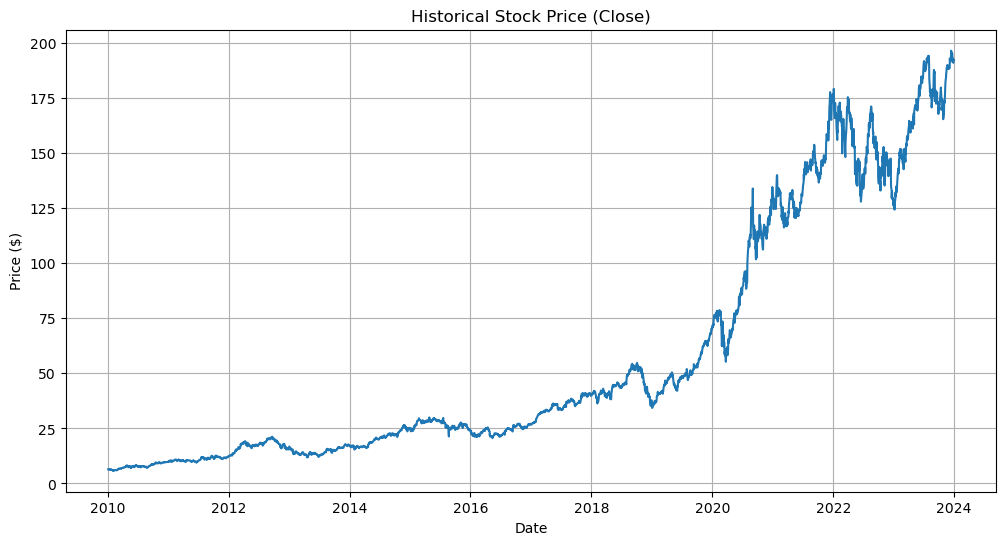

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['Close'])
plt.title("Historical Stock Price (Close)")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.grid()
plt.show()

## Check for Missing Values

In [6]:
print(df.isnull().sum())

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [7]:
# incase of missing values
# df['Close'].interpolate(method='time', inplace=True)

#  Prepare Data for LSTM

##  Use Close Price for Prediction

In [8]:
data = df['Close'].values.reshape(-1, 1)

##  Normalize Data (0 to 1)

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

## Create Time-Series Windows

In [10]:
def create_dataset(data, window_size=60):
    X, y = [], []
    for i in range(len(data) - window_size - 1):
        X.append(data[i:(i + window_size), 0])
        y.append(data[i + window_size, 0])
    return np.array(X), np.array(y)

window_size = 60  # Use 60 days to predict the next day
X, y = create_dataset(scaled_data, window_size)

## Train-Test Split (80-20)

In [11]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape for LSTM: (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build & Train LSTM Model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test)
)

2025-06-08 17:56:32.514959: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-08 17:56:32.522756: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749405392.530373   76959 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749405392.532657   76959 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749405392.538916   76959 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


I0000 00:00:1749405396.003601   77135 cuda_dnn.cc:529] Loaded cuDNN version 90300


87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0092 - val_loss: 0.0015
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.7707e-04 - val_loss: 0.0024
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.1128e-04 - val_loss: 9.5123e-04
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.7380e-04 - val_loss: 8.1806e-04
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.9521e-04 - val_loss: 0.0015
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.7042e-04 - val_loss: 0.0018
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.7254e-04 - val_loss: 0.0022
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.8252e-04 - val_loss: 7.2006e-04
Epoch 9/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.4584e-04 - val_loss: 0.0017
Epoch 10/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.1938e-04 - val_loss: 0.0023
Epoch 11/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.8516e-04 - val_loss: 6.8848e-04
Epoch 12/50
87/87 ━━━━━━━━━━

# Evaluate predictions

In [13]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [14]:
# Convert to 1D arrays for DataFrame
actual = y_test_actual.flatten()
predicted = predictions.flatten()

# Create a DataFrame
results_df = pd.DataFrame({
    'Actual': actual,
    'Predicted': predicted
})
# Save to CSV
results_df.to_csv('lstm_predictions.csv', index=False)

print("Predictions saved to 'lstm_predictions.csv'")

Predictions saved to 'lstm_predictions.csv'


In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test_actual, predictions)
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
print(f"MAE: ${mae:.2f}, RMSE: ${rmse:.2f}")

MAE: $3.33, RMSE: $4.10


## Plot predictions

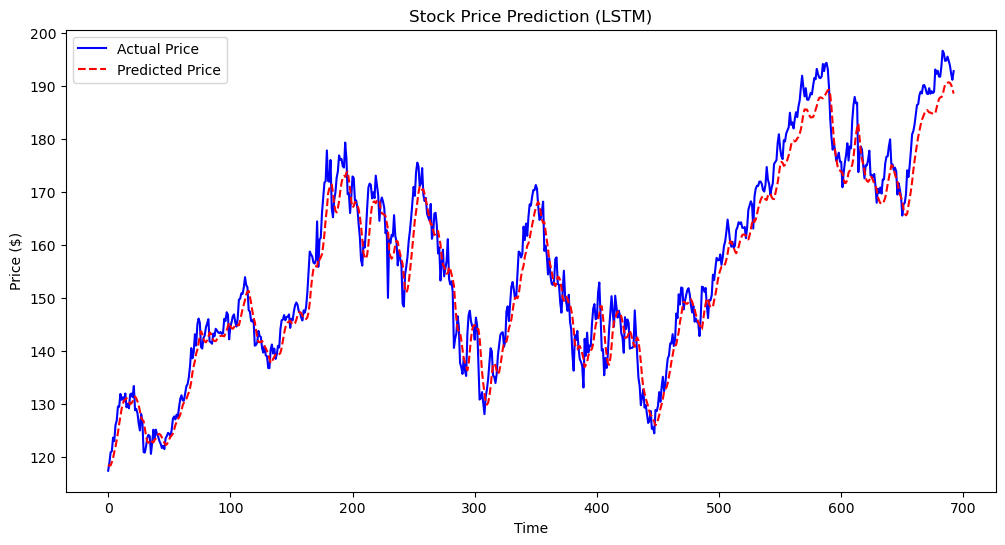

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Price', color='blue')
plt.plot(predictions, label='Predicted Price', color='red', linestyle='--')
plt.title("Stock Price Prediction (LSTM)")
plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.legend()
plt.show()

# Predicti future prices

In [17]:
last_window = scaled_data[-window_size:]
last_window = np.reshape(last_window, (1, window_size, 1))

next_day_pred = model.predict(last_window)
next_day_pred = scaler.inverse_transform(next_day_pred)
print(f"Predicted Next Day Close Price: ${next_day_pred[0][0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Next Day Close Price: $187.98


## Multi-day forecasting

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


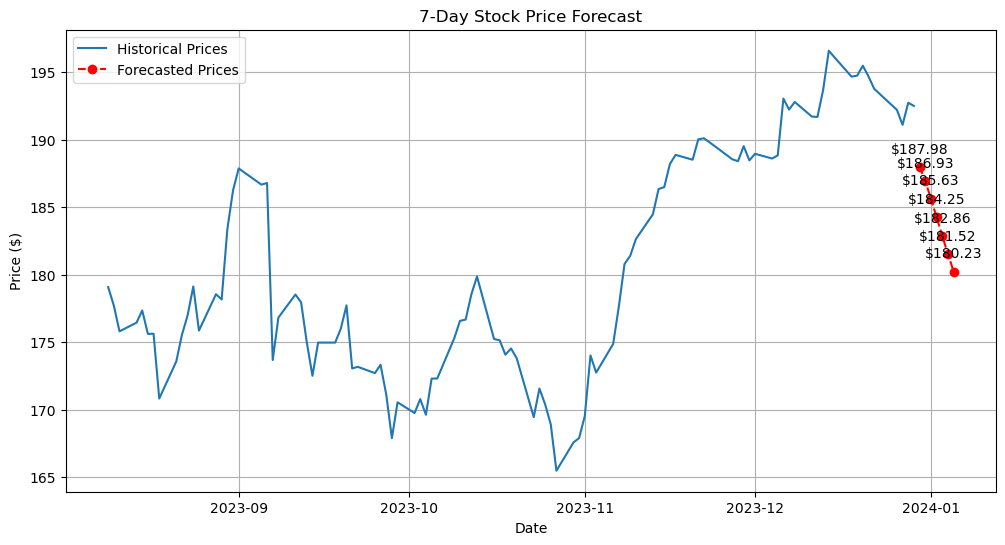

In [18]:
import matplotlib.pyplot as plt

def forecast_future_days(model, last_window, scaler, n_days=7):
    """
    Predicts N days into the future using iterative forecasting
    """
    forecasts = []
    current_window = last_window.copy()
    
    for _ in range(n_days):
        # Predict next day
        next_pred = model.predict(current_window)
        forecasts.append(next_pred[0,0])
        
        # Update window (remove oldest, add prediction)
        current_window = np.roll(current_window, -1, axis=1)
        current_window[0, -1, 0] = next_pred[0,0]
    
    # Inverse transform to original scale
    return scaler.inverse_transform(np.array(forecasts).reshape(-1, 1))

# Forecast 7 days ahead
n_forecast_days = 7
future_prices = forecast_future_days(model, last_window, scaler, n_forecast_days)

# Generate future dates
last_date = df.index[-1]
future_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=1),
    periods=n_forecast_days
)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(df.index[-100:], df['Close'][-100:], label='Historical Prices')
plt.plot(future_dates, future_prices, 'ro--', label='Forecasted Prices')

# Add labels/legend
plt.title(f'{n_forecast_days}-Day Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)

# Annotate forecast values
for i, (date, price) in enumerate(zip(future_dates, future_prices)):
    plt.annotate(f'${price[0]:.2f}', 
                (date, price[0]),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')

plt.show()

# Using prophet model

Importing plotly failed. Interactive plots will not work.
17:58:29 - cmdstanpy - INFO - Chain [1] start processing
17:58:30 - cmdstanpy - INFO - Chain [1] done processing


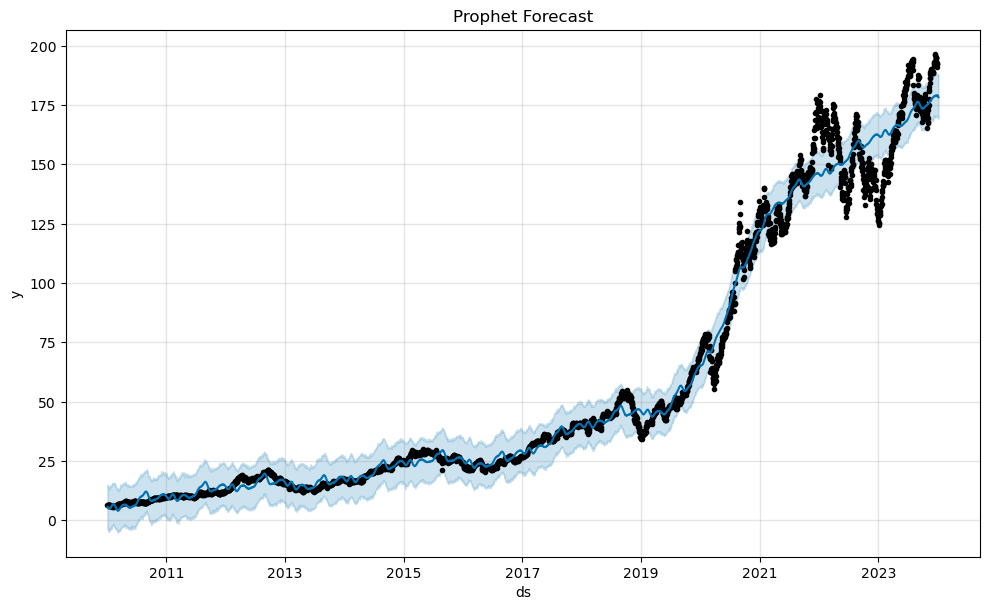

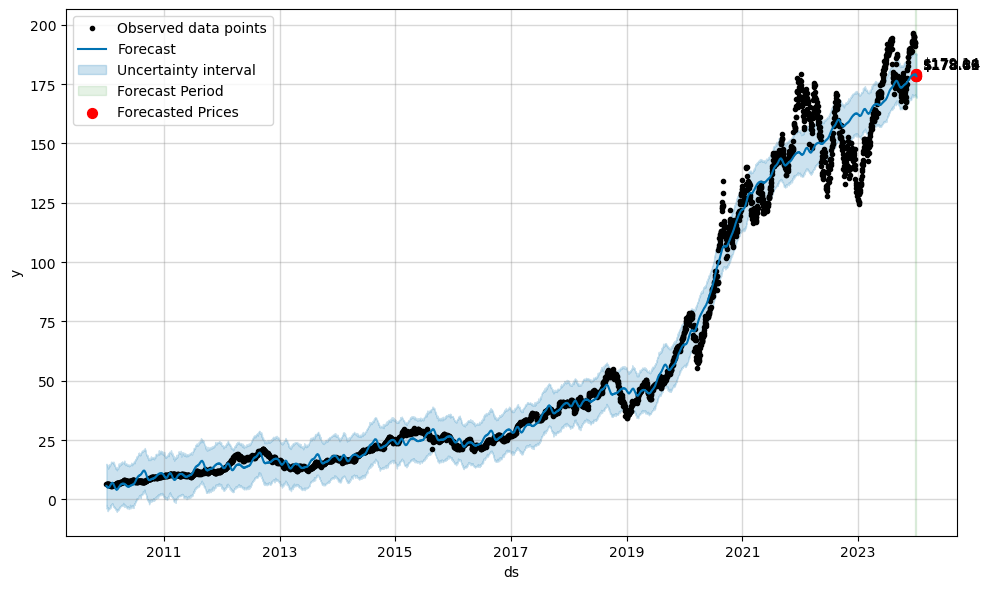

             ds        yhat  yhat_lower  yhat_upper
3522 2023-12-30  179.139726  170.442377  188.026641
3523 2023-12-31  179.078186  169.647237  187.988147
3524 2024-01-01  178.625541  169.628298  188.114735
3525 2024-01-02  178.659645  169.963451  187.550479
3526 2024-01-03  178.611969  169.625759  188.020161
3527 2024-01-04  178.486455  169.705088  187.391205
3528 2024-01-05  178.335523  169.284122  187.642269


In [19]:
from prophet import Prophet
import matplotlib.pyplot as plt

# Prepare data for Prophet (requires 'ds' and 'y' columns)
prophet_df = df.reset_index()[['Date', 'Close']].rename(columns={
    'Date': 'ds',
    'Close': 'y'
})

# 1. Initialize and fit model
model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.05
)
model.fit(prophet_df)

# 2. Create future dataframe (7 days)
future = model.make_future_dataframe(periods=7)
forecast = model.predict(future)

# 3. Plot components
fig1 = model.plot(forecast)
plt.title('Prophet Forecast')
plt.show()

# 4. Plot forecast with historical data
fig2 = model.plot(forecast)
ax = fig2.gca()

# Highlight forecast period
xmin = prophet_df['ds'].max()
xmax = forecast['ds'].max()
ax.axvspan(xmin, xmax, alpha=0.1, color='green', label='Forecast Period')

# Add markers for forecast points
forecast_points = forecast[forecast['ds'] > xmin]
ax.scatter(
    forecast_points['ds'],
    forecast_points['yhat'],
    color='red',
    s=50,
    label='Forecasted Prices'
)

# Annotate values
for _, row in forecast_points.iterrows():
    ax.annotate(
        f"${row['yhat']:.2f}",
        (row['ds'], row['yhat']),
        textcoords="offset points",
        xytext=(5,5),
        ha='left'
    )

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 5. Show forecast dataframe
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7))

In [20]:
# Saving predictions to csv file

import pandas as pd

# Get only the future forecast (after last known date)
xmin = prophet_df['ds'].max()
prophet_forecast_df = forecast[forecast['ds'] > xmin]

# Select relevant columns and rename
prophet_forecast_df = prophet_forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
prophet_forecast_df.rename(columns={
    'ds': 'Date',
    'yhat': 'Predicted',
    'yhat_lower': 'Lower Bound',
    'yhat_upper': 'Upper Bound'
}, inplace=True)

# Optional: Format to 2 decimal places
prophet_forecast_df['Predicted'] = prophet_forecast_df['Predicted'].round(2)
prophet_forecast_df['Lower Bound'] = prophet_forecast_df['Lower Bound'].round(2)
prophet_forecast_df['Upper Bound'] = prophet_forecast_df['Upper Bound'].round(2)

# Save to CSV
prophet_forecast_df.to_csv('prophet_forecast.csv', index=False)

print("Prophet forecasts saved to 'prophet_forecast.csv'")
print(prophet_forecast_df)

Prophet forecasts saved to 'prophet_forecast.csv'
           Date  Predicted  Lower Bound  Upper Bound
3522 2023-12-30     179.14       170.44       188.03
3523 2023-12-31     179.08       169.65       187.99
3524 2024-01-01     178.63       169.63       188.11
3525 2024-01-02     178.66       169.96       187.55
3526 2024-01-03     178.61       169.63       188.02
3527 2024-01-04     178.49       169.71       187.39
3528 2024-01-05     178.34       169.28       187.64


# Comparing the two models

Future Forecast Comparison:
            LSTM_Forecast  Prophet_Forecast
Date                                       
2023-12-30     187.983871        179.139726
2023-12-31     186.931671        179.078186
2024-01-01     185.631821        178.625541
2024-01-02     184.246597        178.659645
2024-01-03     182.862686        178.611969
2024-01-04     181.518967        178.486455
2024-01-05     180.231064        178.335523


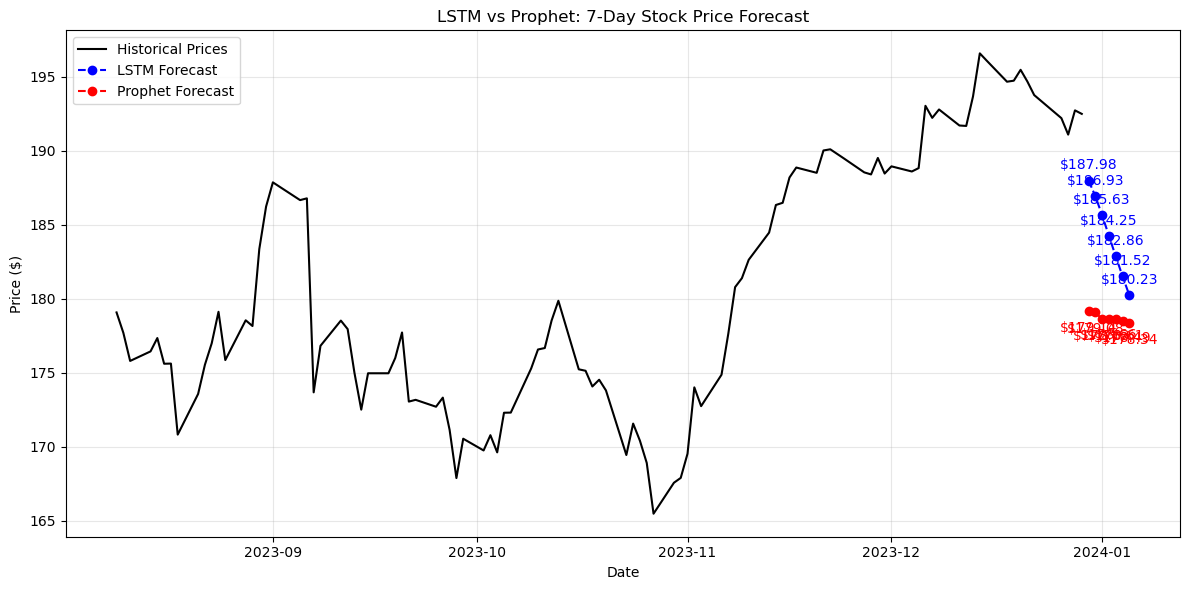


Forecasts saved to 'lstm_vs_prophet_forecast.csv'


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet

# -------------------------------
# 1. Assume these are already defined from your code:
# - df: Original DataFrame with 'Close' prices indexed by Date
# - model (Prophet): Trained Prophet model
# - forecast: Prophet's full forecast output
# - future_prices: LSTM's future forecast (7-day array)
# - last_window: Last input window used in LSTM prediction
# - scaler: Scaler used to inverse transform scaled data
# - model_lstm: Your trained LSTM model
# -------------------------------

# -------------------------------
# 2. Generate Future Dates for LSTM Forecast
last_date = df.index[-1]
future_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=1),
    periods=7
)

# Convert LSTM forecast to DataFrame
lstm_forecast_df = pd.DataFrame({
    'Date': future_dates,
    'LSTM_Forecast': future_prices.flatten()
})
lstm_forecast_df.set_index('Date', inplace=True)

# -------------------------------
# 3. Extract Prophet Forecast
prophet_forecast_df = forecast[['ds', 'yhat']].rename(columns={'yhat': 'Prophet_Forecast'})
prophet_forecast_df['Date'] = pd.to_datetime(prophet_forecast_df['ds'])
prophet_forecast_df.set_index('Date', inplace=True)
prophet_forecast_df = prophet_forecast_df[['Prophet_Forecast']]
prophet_forecast_df = prophet_forecast_df[prophet_forecast_df.index > df.index[-1]]

# -------------------------------
# 4. Combine Forecasts into One DataFrame
comparison_df = pd.concat([
    lstm_forecast_df,
    prophet_forecast_df
], axis=1)

print("Future Forecast Comparison:")
print(comparison_df)

# -------------------------------
# 5. Plotting Both Forecasts Together
plt.figure(figsize=(12, 6))
plt.plot(df.index[-100:], df['Close'][-100:], label='Historical Prices', color='black')
plt.plot(comparison_df.index, comparison_df['LSTM_Forecast'], 'bo--', label='LSTM Forecast')
plt.plot(comparison_df.index, comparison_df['Prophet_Forecast'], 'ro--', label='Prophet Forecast')

# Annotate each point
for i, row in comparison_df.iterrows():
    plt.annotate(f"${row['LSTM_Forecast']:.2f}", 
                 (i, row['LSTM_Forecast']),
                 textcoords="offset points", xytext=(0, 8), ha='center', color='blue')
    plt.annotate(f"${row['Prophet_Forecast']:.2f}", 
                 (i, row['Prophet_Forecast']),
                 textcoords="offset points", xytext=(0, -15), ha='center', color='red')

plt.title('LSTM vs Prophet: 7-Day Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -------------------------------
# 6. Optional: Backtesting Comparison (if you have actual future data)

# If you have actual future prices, e.g., new_data['Close']
# For now, we can only compare visually or save forecasts

# Save forecast to CSV for later analysis
comparison_df.to_csv('lstm_vs_prophet_forecast.csv')
print("\nForecasts saved to 'lstm_vs_prophet_forecast.csv'")

# Cleanin csv file

In [31]:
import pandas as pd

# Load the data with proper handling
try:
    # Read raw data, skipping the first 2 metadata rows
    raw_df = pd.read_csv('AAPL_stock_data.csv', skiprows=2, header=None)
    
    # Verify we have the expected columns
    if len(raw_df.columns) == 6:
        clean_df = raw_df.rename(columns={
            0: 'Date',
            1: 'Price',
            2: 'Close',
            3: 'High',
            4: 'Low',
            5: 'Volume'
        })
    else:
        raise ValueError(f"Unexpected number of columns: {len(raw_df.columns)}")

    # Convert Date column - handle multiple formats
    clean_df['Date'] = pd.to_datetime(clean_df['Date'], errors='coerce', format='mixed')
    
    # Drop any rows where date parsing failed
    clean_df = clean_df.dropna(subset=['Date'])
    
    # Convert numeric columns
    numeric_cols = ['Price', 'Close', 'High', 'Low', 'Volume']
    clean_df[numeric_cols] = clean_df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    
    # Set index and sort
    clean_df.set_index('Date', inplace=True)
    clean_df.sort_index(inplace=True)
    
    # Save cleaned data
    clean_df.to_csv('cleaned_aapl_stock_data.csv')
    
    print("Successfully cleaned data. Sample:")
    print(clean_df.head())

except Exception as e:
    print(f"Error: {str(e)}")
    print("\nDebugging info - first 5 rows:")
    print(raw_df.head() if 'raw_df' in locals() else "Couldn't load data")

Successfully cleaned data. Sample:
               Price     Close      High       Low       Volume
Date                                                           
2010-01-04  6.431897  6.446623  6.382908  6.414465  493729600.0
2010-01-05  6.443017  6.479383  6.409055  6.449629  601904800.0
2010-01-06  6.340531  6.468562  6.333919  6.443016  552160000.0
2010-01-07  6.328812  6.371489  6.282829  6.363975  477131200.0
2010-01-08  6.370888  6.371490  6.283131  6.320397  447610800.0
